# Paquetes

#### Ejercicio

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.layers import LSTM, Dropout, Dense, Conv1D, Attention

In [2]:
import pandas as pd
df = pd.read_csv('./data/df_definitivo_100%.csv', index_col='fecha')
#Tomar solo los datos desde 2005
df = df.loc['2005-01-01':'2023-01-01']
variable_respuesta = 'IPC General histórico, variación mensual'
df = df.dropna(axis=1, how='any')

In [3]:
# Crear los datos de entrada X y la variable de respuesta y
X = df.drop(variable_respuesta, axis=1).values
y = df[variable_respuesta].values

# Separación de datos

In [4]:
# Normalizar los datos de entrada (opcional pero recomendado)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Entrenamiento y Validación

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

# Deep Neural Network

## 1.- Arquitectura

In [6]:
model_dnn = tf.keras.models.Sequential()
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(16, activation = tf.keras.activations.relu))
model_dnn.add(Dense(32, activation = tf.keras.activations.relu))
model_dnn.add(Dense(64, activation = tf.keras.activations.relu))
model_dnn.add(Dense(128, activation = tf.keras.activations.relu))
model_dnn.add(Dense(64, activation = tf.keras.activations.relu))
model_dnn.add(Dense(32, activation = tf.keras.activations.relu))
model_dnn.add(Dense(16, activation = tf.keras.activations.relu))
model_dnn.add(Dense(8, activation = tf.keras.activations.relu))

## Última capa indica tarea de la red
model_dnn.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

model_dnn.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['mean_absolute_error','mean_squared_error','mean_absolute_percentage_error'])

input_shape = X_train.shape
model_dnn.build(input_shape)

model_dnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (173, 1050)               0         
                                                                 
 dense (Dense)               (173, 16)                 16816     
                                                                 
 dense_1 (Dense)             (173, 32)                 544       
                                                                 
 dense_2 (Dense)             (173, 64)                 2112      
                                                                 
 dense_3 (Dense)             (173, 128)                8320      
                                                                 
 dense_4 (Dense)             (173, 64)                 8256      
                                                                 
 dense_5 (Dense)             (173, 32)                 2

## 2.- Entrenamiento

In [7]:
fnnn_fit = model_dnn.fit(X_train, y_train, epochs = 500, batch_size = 32)

Epoch 1/500
6/6 [==============================] - 1s 4ms/step - loss: 0.1936 - mean_absolute_error: 0.3306 - mean_squared_error: 0.1936 - mean_absolute_percentage_error: 13866890.0000
Epoch 2/500
6/6 [==============================] - 0s 4ms/step - loss: 0.1844 - mean_absolute_error: 0.3371 - mean_squared_error: 0.1844 - mean_absolute_percentage_error: 32004588.0000
Epoch 3/500
6/6 [==============================] - 0s 4ms/step - loss: 0.1787 - mean_absolute_error: 0.3238 - mean_squared_error: 0.1787 - mean_absolute_percentage_error: 20106344.0000
Epoch 4/500
6/6 [==============================] - 0s 4ms/step - loss: 0.1646 - mean_absolute_error: 0.3193 - mean_squared_error: 0.1646 - mean_absolute_percentage_error: 30062560.0000
Epoch 5/500
6/6 [==============================] - 0s 4ms/step - loss: 0.1562 - mean_absolute_error: 0.3105 - mean_squared_error: 0.1562 - mean_absolute_percentage_error: 23790634.0000
Epoch 6/500
6/6 [==============================] - 0s 5ms/step - loss: 0.14

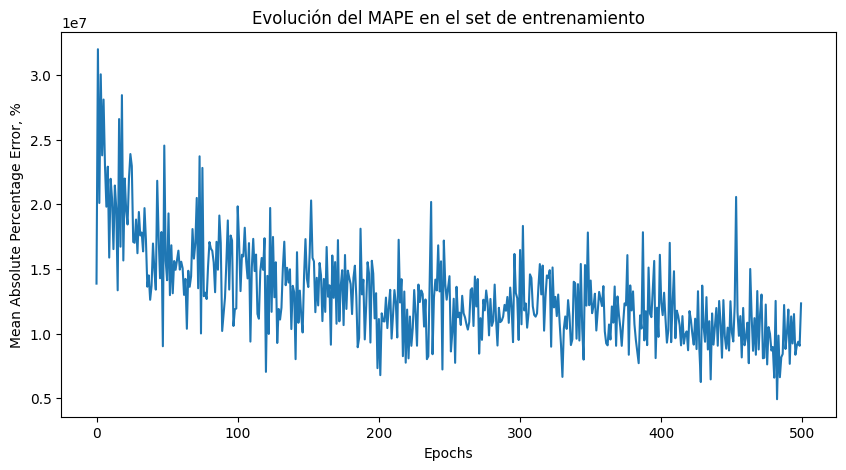

In [8]:
fig = plt.figure(figsize = (10,5))
plt.plot(fnnn_fit.history['mean_absolute_percentage_error'])
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Percentage Error, %')
plt.title('Evolución del MAPE en el set de entrenamiento')
plt.show()

## 3.- Evaluación

In [9]:
loss, mae, mse, mape = model_dnn.evaluate(X_test,y_test)
dict_metrics_dnn = {'loss':loss, 'mae':mae, 'mse':mse, 'mape':mape}

2/2 [==============================] - 0s 4ms/step - loss: 0.0779 - mean_absolute_error: 0.2264 - mean_squared_error: 0.0779 - mean_absolute_percentage_error: 16250577.0000


## 4.- Predicción

2/2 [==============================] - 0s 2ms/step


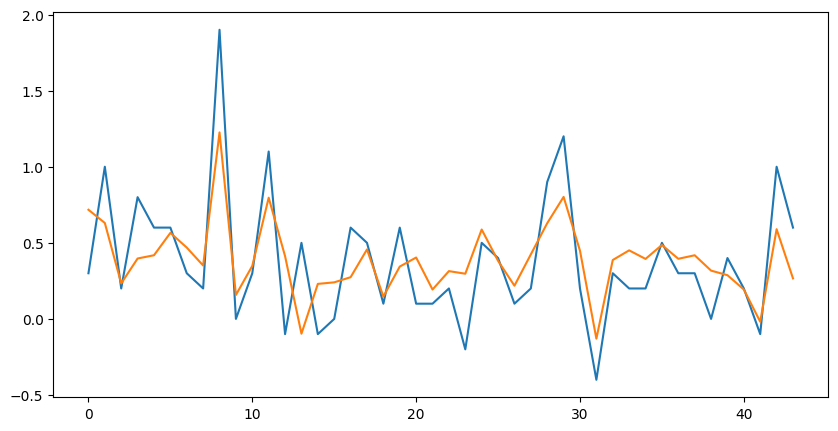

In [10]:
pred_2022_DNN = model_dnn.predict(X_test)
# Graficar resultados
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(pred_2022_DNN, label='Predicción')

# Long-Short Term Memory

## 0.- Preprocesamiento LSTM

<img src= "Datos/time_series.png">

In [11]:
def reshape_for_lstm(data, timesteps, features):
    """
    Reshapes an array into the format required by an LSTM model.

    Args:
        data (numpy.ndarray): Input data array.
        timesteps (int): Number of time steps in the input sequence.
        features (int): Number of features at each time step.

    Returns:
        numpy.ndarray: Reshaped array.
    """
    # Calculate the number of samples
    num_samples = data.shape[0] - timesteps + 1

    # Create an empty array for reshaped data
    reshaped_data = np.zeros((num_samples, timesteps, features))

    # Reshape the data
    for i in range(num_samples):
        reshaped_data[i] = data[i:i + timesteps, :]

    return reshaped_data


In [12]:
n_steps = 6

predictores_lstm = reshape_for_lstm(X,n_steps,X.shape[1])
y = pd.DataFrame(y)
target_lstm = y.drop(y.index[0:n_steps-1])

X_lstm_2022 = reshape_for_lstm(X, n_steps,X.shape[1])

In [13]:
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(predictores_lstm, target_lstm.values, test_size = 0.20, random_state = 42)

## 1.- Arquitectura

In [14]:
model_LSTM = tf.keras.models.Sequential()

#model_LSTM.add(LSTM(32,input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2]), activation = tf.keras.activations.relu))#,return_sequences=True))

model_LSTM.add(Conv1D(filters=128, kernel_size=3, 
                      activation= tf.keras.activations.relu, 
                      input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2])))

## Capa de LSTM
model_LSTM.add(LSTM(128, 
                    activation = tf.keras.activations.relu, 
                    return_sequences=True))
model_LSTM.add(LSTM(64, 
                    activation = tf.keras.activations.relu, 
                    return_sequences=True))
model_LSTM.add(LSTM(32, 
                    activation = tf.keras.activations.relu))

## Capa de neuronas clásicas
model_LSTM.add(Dense(32, 
                     activation = tf.keras.activations.linear))

## Última capa indica función de la red
model_LSTM.add(Dense(1, activation = tf.keras.activations.linear))

model_LSTM.compile(optimizer = 'adam',
                   loss = 'mean_squared_error',
                   metrics = ['mean_absolute_error','mean_squared_error','mean_absolute_percentage_error'])

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            403328    
                                                                 
 lstm (LSTM)                 (None, 4, 128)            131584    
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 597,825
Trainable params: 597,825
Non-tr

## 2.- Entrenamiento

In [15]:
lstm_fit = model_LSTM.fit(X_train_lstm, Y_train_lstm, epochs = 400, batch_size = 150)

Epoch 1/400
2/2 [==============================] - 4s 18ms/step - loss: 0.2956 - mean_absolute_error: 0.4299 - mean_squared_error: 0.2956 - mean_absolute_percentage_error: 1048945.7500
Epoch 2/400
2/2 [==============================] - 0s 19ms/step - loss: 0.1926 - mean_absolute_error: 0.3349 - mean_squared_error: 0.1926 - mean_absolute_percentage_error: 20346720.0000
Epoch 3/400
2/2 [==============================] - 0s 26ms/step - loss: 0.3601 - mean_absolute_error: 0.5053 - mean_squared_error: 0.3601 - mean_absolute_percentage_error: 67806448.0000
Epoch 4/400
2/2 [==============================] - 0s 20ms/step - loss: 0.1838 - mean_absolute_error: 0.3269 - mean_squared_error: 0.1838 - mean_absolute_percentage_error: 20940766.0000
Epoch 5/400
2/2 [==============================] - 0s 15ms/step - loss: 0.1989 - mean_absolute_error: 0.3409 - mean_squared_error: 0.1989 - mean_absolute_percentage_error: 16609039.0000
Epoch 6/400
2/2 [==============================] - 0s 16ms/step - loss:

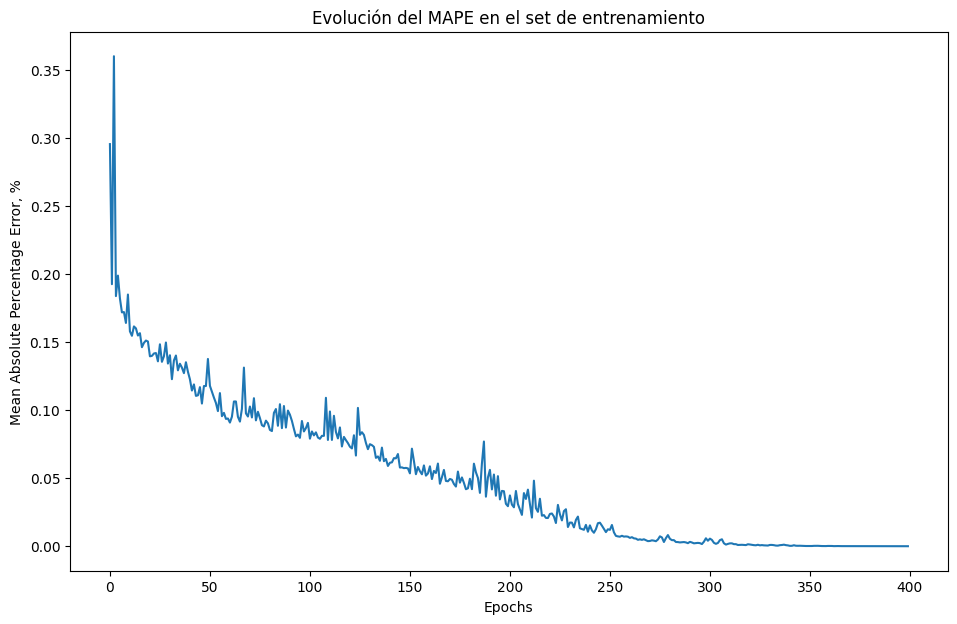

In [16]:
fig = plt.figure(figsize = (7*(1+np.sqrt(5))/2,7))
#plt.plot(lstm_fit.history['mean_absolute_percentage_error'])
plt.plot(lstm_fit.history['mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Percentage Error, %')
plt.title('Evolución del MAPE en el set de entrenamiento')
#plt.yscale('log')
#plt.ylim([0,200])
plt.show()

In [17]:
#lstm_fit.history['mean_absolute_percentage_error'][-1]

## 3.- Evaluación

In [18]:
loss, mae, mse, mape = model_LSTM.evaluate(X_test_lstm,Y_test_lstm)
dict_metrics_lstm = {'loss':loss, 'mae':mae, 'mse':mse, 'mape':mape}

2/2 [==============================] - 0s 6ms/step - loss: 0.1049 - mean_absolute_error: 0.2481 - mean_squared_error: 0.1049 - mean_absolute_percentage_error: 33282522.0000


## 4.- Predicción

In [19]:
pred_2022_LSTM = np.squeeze(model_LSTM.predict(X_test_lstm))

2/2 [==============================] - 0s 5ms/step


# Comparación de modelos

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

reg = LinearRegression().fit(X_train, y_train)
y_reg = reg.predict(X_test) 
dict_metrics_reg = {'loss':0, 'mae':mean_absolute_error(y_test,y_reg), 'mse':mean_squared_error(y_test,y_reg), 'mape':mean_absolute_percentage_error(y_test,y_reg)}

In [21]:
def simetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the symmetric mean absolute percentage error (sMAPE).

    Args:
        y_true (numpy.ndarray): Ground truth values.
        y_pred (numpy.ndarray): Predicted values.

    Returns:
        float: sMAPE value.
    """
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100
smape_dnn = simetric_mean_absolute_percentage_error(y_test, pred_2022_DNN)
smape_lstm = simetric_mean_absolute_percentage_error(Y_test_lstm, pred_2022_LSTM)
smape_reg = simetric_mean_absolute_percentage_error(y_test, y_reg)
dict_metrics_reg['smape'] = smape_reg
dict_metrics_dnn['smape'] = smape_dnn
dict_metrics_lstm['smape'] = smape_lstm


1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 4ms/step


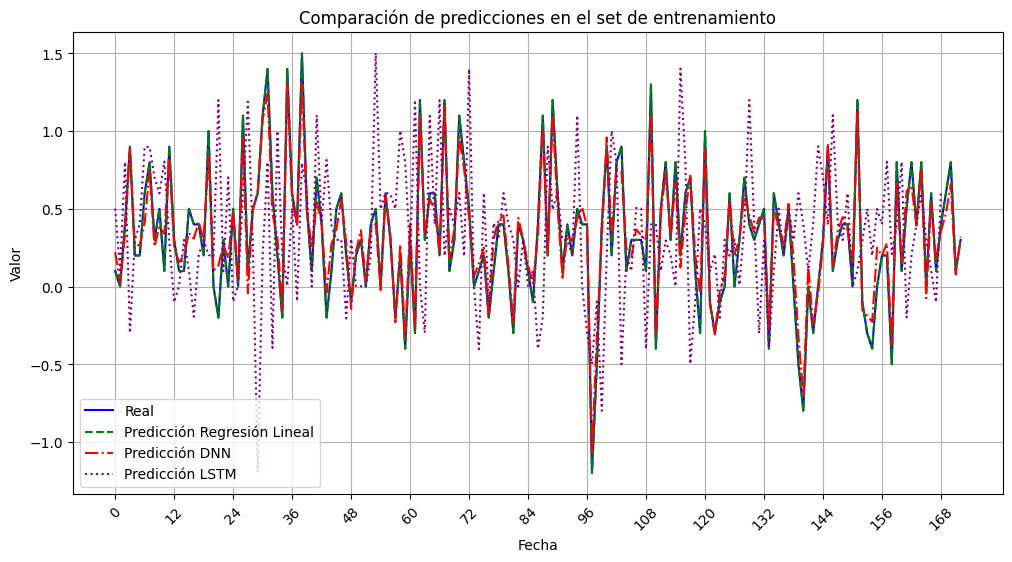

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones de los diferentes modelos
y_reg = reg.predict(X_train)
y_dnn = model_dnn.predict(X_train)
y_lstm = np.squeeze(model_LSTM.predict(X_train_lstm))

# Configurar los estilos y colores de las líneas
line_styles = ['-', '--', '-.', ':']
colors = ['blue', 'green', 'red', 'purple']
labels = ['Real', 'Predicción Regresión Lineal', 'Predicción DNN', 'Predicción LSTM']

# Graficar los resultados en el set de entrenamiento
plt.figure(figsize=(12, 6))
for i, y_pred in enumerate([y_train, y_reg, y_dnn, y_lstm]):
    plt.plot(y_pred, linestyle=line_styles[i], color=colors[i], label=labels[i])

# Configurar el formato del eje x para mostrar la fecha cada 12 meses y rotar 45 grados
plt.xticks(np.arange(0, len(y_train), step=12), rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de predicciones en el set de entrenamiento')
plt.legend()
plt.grid(True)
plt.show()


2/2 [==============================] - 0s 5ms/step


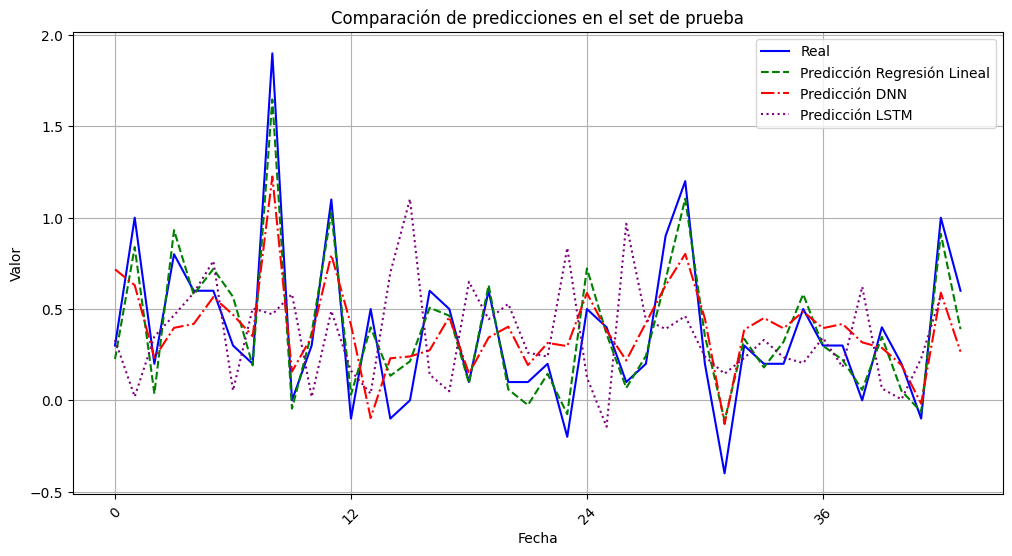

In [23]:
# Obtener las predicciones en el conjunto de prueba
pred_reg = reg.predict(X_test)
pred_dnn = model_dnn.predict(X_test)
pred_lstm = np.squeeze(model_LSTM.predict(X_test_lstm))

# Configurar los estilos y colores de las líneas
line_styles = ['-', '--', '-.', ':']
colors = ['blue', 'green', 'red', 'purple']
labels = ['Real', 'Predicción Regresión Lineal', 'Predicción DNN', 'Predicción LSTM']

# Graficar las predicciones en el conjunto de prueba
plt.figure(figsize=(12, 6))
for i, pred in enumerate([y_test, pred_reg, pred_dnn, pred_lstm]):
    plt.plot(pred, linestyle=line_styles[i], color=colors[i], label=labels[i])

# Configurar el formato del eje x para mostrar la fecha cada 12 meses y rotar 45 grados
plt.xticks(np.arange(0, len(y_test), step=12), rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de predicciones en el set de prueba')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Evaluar el desempeño de los modelos
print('Métricas de desempeño en el set de prueba')
print('------------------------------------------------')
print('Regresión Lineal')
print(dict_metrics_reg['smape'])
print('DNN')
print(dict_metrics_dnn['smape'])
print('LSTM')
print(dict_metrics_lstm['smape'])


Métricas de desempeño en el set de prueba
------------------------------------------------
Regresión Lineal
54.87100582346466
DNN
95.7076496988286
LSTM
104.7911874600523
